<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Analog2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
pip install dtw-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
pip install statsmodels==0.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
import time
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV, Lasso, Ridge, BayesianRidge, LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from math import sqrt
from dtw import *
from scipy import stats
import statsmodels.tools.eval_measures as bias
from statsmodels.tsa.ar_model import AutoReg
%matplotlib inline

sns.set_theme(style="white")

In [65]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path        = 'https://drive.google.com/uc?export=download&id=' 
URL_Demanda = 'https://drive.google.com/file/d/1xcpXDTE7H6EBMLOkic5lq-lzSwiLG2ZS/view?usp=sharing'

df_Demanda  = pd.read_csv(path + URL_Demanda .split('/')[-2], usecols=[0] ) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,], 1,2,3,4,5,6,7,8,9,10,11,12,13,15,
df_Demanda.dropna(inplace=True)
serie = df_Demanda.to_numpy()
serie = StandardScaler().fit_transform(serie)
serie = serie.ravel()  ## Con esto quitamos el bracket o corchete en cada uno de los elementos del arreglo

In [66]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [67]:
def diff(list1,list2):
    difference = []
    zip_object = zip(list1, list2)
    for list1_i, list2_i in zip_object:
        difference.append(list1_i-list2_i)
    return difference

In [68]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; NARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-"; MAGE="FF00FF";
def print_serie2(serie_,prototipo_,title_,ytitle_,xtitle_,sizex_=8,sizey_=5,namefile_='fig_t16_serie.png'):
    fig, ax1 = plt.subplots(figsize=(sizex_,sizey_))
    plt.title(title_,fontsize='x-large',color=NARA)
    ax1.set_xlabel(xtitle_, color=NARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=NARA, fontsize='large')
    plt.tick_params(colors = NARA, which='both')
    ax1.spines['bottom'].set_color(NARA)
    ax1.spines['top'   ].set_color(NARA) 
    ax1.spines['right' ].set_color(NARA)
    ax1.spines['left'  ].set_color(NARA)
    if len(prototipo_) != 0: 
        plt.plot(prototipo_,alpha=0.6, linestyle='dashed', color='red', linewidth=3)
    for p in serie_:
        plt.plot(p,alpha=0.3, linewidth=2)    
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [69]:
## Preparamos la información para graficar la importancia y las posiciones en Random Forest Regressor
def print_importances(model_,labels_,namefile_):
    i=0
    labels = [str(x) for x in labels_]
    labels_importances = []
    for feature in model_.feature_importances_:
        labels_importances.append((feature,labels[i]))
        i=i+1   
    labels_importances.sort(key=lambda tup: tup[0], reverse=False)
    importances = []
    labels      = []
    for tup in labels_importances:
        importances.append(tup[0])
        labels.append(tup[1])
    fig, ax = plt.subplots()
    y_pos = np.arange(len(importances))
    ax.set_yticks(ticks=y_pos)
    ax.barh(labels, importances, align='center',color=CYAN)
    ax.invert_yaxis()
    ax.set_xlabel('Importancia', color=NARA, fontsize='large')
    ax.set_ylabel('Variable', color=NARA, fontsize='large')
    ax.set_title( 'Importancia de las variables del bosque aleatorio', color=NARA, fontsize='large')    
    plt.tick_params(colors = NARA, which='both')
    ax.spines['bottom'].set_color(NARA)
    ax.spines['top'   ].set_color(NARA) 
    ax.spines['right' ].set_color(NARA)
    ax.spines['left'  ].set_color(NARA)
    plt.savefig(namefile_, transparent=True)   
    plt.show()

In [70]:
def OLSstep(X, Y, X_2, pi_step_=0.001,verbose_=False):
    model   = sm.OLS(Y, X)
    results = model.fit()
    prediction_Y2 = results.predict(X_2)

    ## Ordenamos los valores 'pi' y se selecciona el más grande.
    i = 0
    pvalues = []
    for pi in results.pvalues:
        pvalues.append((i,pi))
        i = i + 1
    pvalues.sort(key=lambda tup: tup[1], reverse=True) ## Ordenamos por 'pi'
    (i, pi) = pvalues[0]  

    while pi > pi:
        X   = sm.add_constant(X)
        X_2 = sm.add_constant(X_2)   
        if verbose_==True:
            print('Retiramos regresor ---> X' + str(i))
        X   = np.delete(arr=X,   obj=i+0, axis=1)
        X_2 = np.delete(arr=X_2, obj=i+0, axis=1)   
        model   = sm.OLS(Y, X)
        results = model.fit()

        ## Ordenamos los valores 'pi' y se selecciona el más grande
        i = 0
        pvalues = []
        for pi in results.pvalues:
            pvalues.append((i,pi))
            i = i + 1
        pvalues.sort(key=lambda tup: tup[1], reverse=True) ## Ordenamos por 'pi'
        (i, pi) = pvalues[0]
        #prediction   = results.predict(X)   ## Ajuste
        prediction_Y2 = results.predict(X_2) ## Pronóstico
    if len(prediction_Y2) == 0:      
        if verbose_==True:
            print('>>> Warning, no variable was significant in the regression.')
        model   = sm.OLS(Y, X)
        results = model.fit()
        prediction_Y2 = results.predict(X_2)
        
    if verbose_==True:
        print(results.summary())
    return prediction_Y2   

In [71]:
def RF(X, Y, X_2,labels_,typedist_,verbose_=False):
    model         = RandomForestRegressor(random_state=42)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    if verbose_==True:
        print_importances(model_=model,labels_=labels_,namefile_='fig_t16_importance_'+typedist_+'_'+'RF')
        print('Parámetros utilizados RF')
        print("bootstrap:         {}".format(model.bootstrap))
        print("n_estimators:      {}".format(model.n_estimators))
        print("max_features:      {}".format(model.max_features))
        print("max_depth:         {}".format(model.max_depth))
        print("min_samples_leaf:  {}".format(model.min_samples_leaf))
        print("min_samples_split: {}".format(model.min_samples_split))
    return prediction_Y2   

In [72]:
def AutoRF(X, Y, X_2,labels_,typedist_,verbose_=False):
## https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    #nestlist = []
    #for i in range(10, 320, 50):
    #    nestlist.append(i)
    #param_grid = { 
    #'bootstrap': [True, False],
    #'n_estimators': nestlist,
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    #'min_samples_leaf': [1, 2, 4],
    #'min_samples_split': [2, 5, 10],}
    nestlist = []
    for i in range(10, 320, 50):
        nestlist.append(i)
    param_grid = { 
        'bootstrap': [True, False],
        'n_estimators': nestlist,
        'max_features': ['auto', 'sqrt',],
        'max_depth' : [10, 20, None]}

    model = RandomForestRegressor(random_state=42)
    clf   = GridSearchCV(estimator=model, param_grid=param_grid, cv=5).fit(X, Y)
    model         = clf.best_estimator_
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)

    if verbose_==True:
        print_importances(model_=model,labels_=labels_,namefile_='fig_t16_importance_'+typedist_+'_'+'AutoRF')
        print('Parameters used')
        print("bootstrap:         {}".format(model.bootstrap))
        print("n_estimators:      {}".format(model.n_estimators))
        print("max_features:      {}".format(model.max_features))
        print("max_depth:         {}".format(model.max_depth))
        print("min_samples_leaf:  {}".format(model.min_samples_leaf))
        print("min_samples_split: {}".format(model.min_samples_split))        
    return prediction_Y2   

In [73]:
def Boosting(X, Y, X_2,typedist_,verbose_=False):
    model         = GradientBoostingRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2 

In [74]:
def Bagging(X, Y, X_2,typedist_,verbose_=False):
    model         = BaggingRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   

In [75]:
def AdaBoost(X, Y, X_2,typedist_,verbose_=False):
    model         = AdaBoostRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2 

In [76]:
def LinearReg(X, Y, X_2,typedist_,verbose_=False):
    model         = LinearRegression()
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   

In [77]:
def BayesRidge(X, Y, X_2,typedist_,verbose_=False):
    model         = BayesianRidge(compute_score=True)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2) 
    return prediction_Y2   

In [78]:
def LassoReg(X, Y, X_2,typedist_,verbose_=True):
    model         = Lasso(alpha=0.1)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2  

In [79]:
def RidgeReg(X, Y, X_2,typedist_,verbose_=False):
    model         = Ridge(alpha=0.1)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   

In [80]:
def PLS(X, Y, X_2,n_components,typedist_,verbose_=False):
    model         = PLSRegression(n_components=n_components)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2

In [81]:
def PCR(X, Y, X_2,n_components,typedist_,verbose_=False):
## https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html
    model         = make_pipeline(PCA(n_components=n_components), LinearRegression())
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   

In [82]:
def VotingEnsemble(X, Y, X_2,verbose_=False):  
    ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    gb  = GradientBoostingRegressor(random_state=42)
    rf  = RandomForestRegressor(random_state=42)
    br  = BaggingRegressor(random_state=42)
    ab  = AdaBoostRegressor(random_state=42)
    gb.fit(X, Y)
    rf.fit(X, Y)
    br.fit(X, Y)
    ab.fit(X, Y)
    voting = VotingRegressor([("gb",gb), ("rf",rf), ("br",br), ("ab",ab)]) #
    voting.fit(X, Y)
    prediction_Y2 = voting.predict(X_2)    
    if verbose_ == True:
        predgb  = gb.predict(X_2)
        predrf  = rf.predict(X_2)
        predbr  = br.predict(X_2)  
        predab  = ab.predict(X_2) 
        ## https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.plot.html Markers, Line styles ,Colors
        fig, ax = plt.subplots(figsize=(19,10))
        plt.plot(predgb,  "md" , label="GradientBoostingRegressor") ## go- rs 
        plt.plot(predrf,  "b^" , label="RandomForestRegressor")
        plt.plot(predbr,  "go-", label="BaggingRegressor")
        plt.plot(predab,  "kD" , label="AdaBoostRegressor")
        plt.plot(prediction_Y2, "r*", ms=10, label="VotingEnsemble")
        plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
        plt.ylabel("demanda estandarizada", color=NARA, fontsize='large')
        plt.xlabel("training samples", color=NARA, fontsize='large')
        plt.legend(loc="best")
        plt.title("Pronósticos de ensambles y su promedio", color=NARA, fontsize='large')
        plt.tick_params(colors = NARA, which='both')
        ax.spines['bottom'].set_color(NARA)
        ax.spines['top'   ].set_color(NARA) 
        ax.spines['right' ].set_color(NARA)
        ax.spines['left'  ].set_color(NARA)
        plt.savefig("fig_t16_VotingEnsemble", transparent=True) 
        plt.show()
    return prediction_Y2   

In [83]:
def VotingLinear(X, Y, X_2,verbose_=False):  
    ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    pl = PLSRegression(n_components=1)
    lr = LinearRegression()
    ri = Ridge(alpha=0.1)
    la = Lasso(alpha=0.1)    
    pc = make_pipeline(PCA(n_components=1), LinearRegression())
    pl.fit(X, Y)
    lr.fit(X, Y)
    ri.fit(X, Y)
    la.fit(X, Y)
    pc.fit(X, Y)
    voting = VotingRegressor([("lr",lr),("ri",ri),("la",la),("pc",pc)]) #,("pl",pl)
    voting.fit(X, Y)
    prediction_Y2 = voting.predict(X_2)    
    if verbose_ == True:
        predpl = pl.predict(X_2)
        predlr = lr.predict(X_2)
        predri = ri.predict(X_2)
        predla = la.predict(X_2)
        predpc = pc.predict(X_2)
        ## https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.plot.html Markers, Line styles ,Colors
        fig, ax = plt.subplots(figsize=(17,9))
        plt.plot(predpl,  "md" , label="PLSRegression")
        plt.plot(predlr,  "b^" , label="LinearRegression")
        plt.plot(predri,  "go-", label="Ridge")
        plt.plot(predla,  "ys" , label="Lasso")
        plt.plot(predpc,  "cs" , label="PCR")
        plt.plot(prediction_Y2, "r*", ms=10, label="VotingLinear")
        plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
        plt.ylabel("demanda estandarizada", color=NARA, fontsize='large')
        plt.xlabel("training samples", color=NARA, fontsize='large')
        plt.legend(loc="best")
        plt.title("Pronósticos lineales y su promedio", color=NARA, fontsize='large')
        plt.tick_params(colors = NARA, which='both')
        ax.spines['bottom'].set_color(NARA)
        ax.spines['top'   ].set_color(NARA) 
        ax.spines['right' ].set_color(NARA)
        ax.spines['left'  ].set_color(NARA)
        plt.savefig("fig_t16_VotingLinear", transparent=True) 
        plt.show()
    return prediction_Y2   

In [84]:
## Calcula distancia euclidiana
def euclidean(neig1, neig2):
	  distance = 0.0
	  for i in range(len(neig1)):
		    distance += (neig1[i] - neig2[i])**2
	  return sqrt(distance)

In [85]:
def analogo_knn(serie,vsele,k=10,tol=0.8,n_components=3,typedist='pearson',typereg='OLSstep',verbose=False):    
#    vsele      : Tamanio de la ventana de selección
#    k          : Número de vecinos a buscar k
#    tol        : Tolerancia de tamaño de ventanas para seleccion de vecinos
#    typedist   : medida de distancia, 'euclidian' o 'pearson' o 'dtw' 

    t_o = time.time()
    n = len(serie) ## longitud total de la serie

    ## PASO 1: Selección de las ventanas de mayor correlación.

    ## Calculamos la distancia entre todos los vecinos.
    distances = []
    Y = serie[n-vsele:n]           ## últimos datos
    for i in range(n-2*vsele):                              
        if  typedist == 'dtw':     ## dynamic time warping
            dist = dtw(Y, serie[i:i+vsele]).distance  
        elif typedist == 'euclidian':
            dist = euclidean(Y,serie[i:i+vsele])
        else:
            dist = np.corrcoef(Y,serie[i:i+vsele])[1,0]
        if dist > 0:
            distances.append((i, dist))
        
    ## Calculamos el vecindario por distancia de menor a mayor y se guardan las posiciones.
    if typedist == 'pearson':
        ## En caso de pearson se ordena al revés, nos interesan los mayor correlación.
        distances.sort(key=lambda tup: tup[1], reverse=True)
    else:
        ## En caso de pearson se ordena al revés, nos interesan los de menor distancia.
        distances.sort(key=lambda tup: tup[1], reverse=False)

    neighbors  = []
    neighbors2 = []
    positions  = []

    ## Calculamos los k vecinos mas cercanos y guardamos las posiciones.
    i = 0
    for pos, dis in distances:
        if i==0:      
            positions.append(pos)   
            neighbors.append(serie[pos:pos+vsele])
            neighbors2.append(serie[pos+vsele:pos+2*vsele])  
        else:
            bandera = True
            for p in positions:
                 ## si ya teniamos una posición en la lista que pase la tolerancia, ya no la guardamos 
                if (abs(pos - p) < tol*vsele):
                    bandera = False
                    i = i - 1
                    break
            if bandera == True:
                ## Guarda nuevo vecino
                positions.append(pos)   
                neighbors.append(serie[pos:pos+vsele])
                neighbors2.append(serie[pos+vsele:pos+2*vsele])  
                bandera = False
        i = i + 1
        if i == k:
            break
    if verbose==True:
        print('positions KNN:', positions) ## posición de los k vecinos mas cercanos

    neighbors  = np.array(neighbors)  
    neighbors2 = np.array(neighbors2)    
    vacia = []
    if verbose==True:
        print_serie2(neighbors,Y,'Selección con KNN:'+typedist,'demanda','time',8,5,'fig_t16_X_'+typedist+'_'+typereg)

    t_sel = time.time() - t_o

    ## PASO 2: Regresión entre los vecinos mas cercanos 'X' y la última ventana 'Y'

    ## Definimos nuestros regresores   
    X   = (neighbors.T ).tolist()
    X_2 = (neighbors2.T).tolist()
    Y   = (Y).tolist()
    prediction_Y2 = []

    ## -- Random forest regression --
    if typereg == 'RF':
        prediction_Y2 = RF(X,Y,X_2,labels_=positions,typedist_=typedist,verbose_=verbose)

    ## -- OLS with Stepwise --
    if typereg == 'OLSstep':
        prediction_Y2 = OLSstep(X,Y,X_2, pi_step_=0.001,verbose_=verbose)

    ## -- Gradiant boosting regression --
    if typereg == 'Boosting':
        prediction_Y2 = Boosting(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Bagging regression --
    if typereg == 'Bagging':
        prediction_Y2 = Bagging(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Linear regression --
    if typereg == 'LinearReg':
        prediction_Y2 = LinearReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Ada boosting --
    if typereg == 'AdaBoost':
        prediction_Y2 = AdaBoost(X, Y, X_2,typedist_=typedist,verbose_=verbose)  

    ## -- Bayesian Ridge --
    if typereg == 'BayesRidge':
        prediction_Y2 = BayesRidge(X, Y, X_2,typedist_=typedist,verbose_=verbose)  

    ## -- Lasso regression --
    if typereg == 'LassoReg':
        prediction_Y2 = LassoReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Ridge regression --
    if typereg == 'RidgeReg':
        prediction_Y2 = RidgeReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)

    ## -- PLS Regression --
    if typereg == 'PLS':
        prediction_Y2 = PLS(X, Y, X_2,n_components=n_components,typedist_=typedist,verbose_=verbose)

    ## -- PCA Regression --
    if typereg == 'PCR':
        prediction_Y2 = PCR(X, Y, X_2,n_components=n_components,typedist_=typedist,verbose_=verbose)

    ## -- Voting regression with ensemble models -- 
    if typereg == 'VotingEnsemble':
        prediction_Y2 = VotingEnsemble(X,Y,X_2,verbose_=verbose)

    ## -- Voting regression with linear model -- 
    if typereg == 'VotingLinear':
        prediction_Y2 = VotingLinear(X,Y,X_2,verbose_=verbose)
        
    ## -- Random forrest regression with GridSearchCV--
    if typereg == 'AutoRF':
        prediction_Y2 = AutoRF(X, Y, X_2,labels_=positions,typedist_=typedist,verbose_=verbose)        

    if verbose==True:
        print_serie2(neighbors2,prediction_Y2, 'Pronóstico - ' + typedist+' - ' + typereg ,'Demanda','Tiempo',8,5,'fig_t16_Y2_'+typedist+'_'+typereg)

    t_reg = time.time() - t_sel - t_o
    #if typedist=='pearson':
    #  t_sel =2.2038
    #if typedist=='euclidian':
    #  t_sel =23.4583

    if len(prediction_Y2) == 0:
        prediction_Y2=[serie[-1]] * vsele
        print(">>> analogo_knn: Pronóstico no calculado")

    ## Dibujamos un ejemplo de espacio análogo
    if True:
        fig, ax = plt.subplots()
        ax.legend(['First line', 'Second line'])
        serie1=serie[positions[0]:positions[0]+2*vsele]
        serie2=serie[positions[1]:positions[1]+2*vsele]
        serie3=serie[positions[2]:positions[2]+2*vsele]
        serie4=serie[positions[3]:positions[3]+2*vsele]
        serie5=serie[positions[4]:positions[4]+2*vsele]
        serie6=serie[positions[5]:positions[5]+2*vsele]
        ax.plot(serie1, label='X$_1$')
        ax.plot(serie2, label='X$_2$')
        ax.plot(serie3, label='X$_3$')
        ax.plot(serie4, label='X$_4$')
        ax.plot(serie5, label='X$_5$')
        ax.plot(serie6,label='X$_6$')
        ax.plot(Y,label='Y', linewidth=3, color='r')   
        c = np.concatenate((Y,prediction_Y2), axis=0)   
        ax.plot(c, label='$Y\'$', linewidth=3, color='r',linestyle='--')      
        plt.legend()
        plt.axvline(x = vsele,linestyle='-.') # '-', '--', '-.', ':',
        ax.set(xlabel='time (5 min)', ylabel='demand (MW)') #title='High correlation windows'
        ax.grid()
        fig.savefig("test.png")
        plt.show()

    return prediction_Y2, t_sel, t_reg

---
## Pruebas unitarias del método análogo



In [86]:
## Controla las pruebas unitarias al modelo análogo
unit_test =False

In [87]:
## ... (time serie) ... window.window.window.window.window.window.window.window.window.window.window.
##                                           |                                               |       |
##                                           |                                               |       |
##                                           |<------------------ vsele -------------------->|<vpred>|
##                                                       (selection and regression)        (prediction)
##                                                                                                 
##|<---------------------------------------- train ----------------------------------------->| <test>|

## Parámetros del método Análogo
if unit_test:
    periods       = 288       ## Número de periodos en una ventana
    periods_sele  = 1         ## Número de ventanas de selección
    periods_pred  = 1         ## Número de ventanas de pronóstico

    vsele = periods * periods_sele ## Número de periodos para selección
    vpred = periods * periods_pred ## Número de periodos para pronóstico

    k   = 6   ## k:   número de vecinos mas cercanos
    tol = 0.8 ## tol: porcentaje de tolerancia de cercania entre ventanas

    ## Dibujamos la ventana de histórico y los datos de prueba  
    series = []; vacia = []; n = 2
    series.append(serie[len(serie)-n*vsele : len(serie)-vsele+vpred])
    series.append(serie[len(serie)-n*vsele : len(serie)-vsele])
    print_serie2(serie_=series,prototipo_=vacia , title_='Serie de demanda eléctrica', ytitle_='Demanda (estandarizada)',xtitle_='Tiempo', sizex_=20, sizey_=6, namefile_='fig_t15_demanda')

    ## Definimos la ventana de prueba y entrenamiento
    X_train = serie[0 : len(serie) - vpred]
    y_test  = serie[len(serie) - vpred : len(serie)]

    ## Guardamos todos los resultados aquí
    dferror = pd.DataFrame(columns=['distance','regression','MAE','MAPE','timesel','timereg'])

    ## Bandera que activa todos los pronósticos
    debug  = 0
    active = 0

In [88]:
if unit_test:
  distances = ['pearson', 'euclidian']
  methods = ['RF', 'OLSstep', 'Boosting', 'Bagging', 'LinearReg', 'AdaBoost', 'LassoReg', 'RidgeReg', 'PLS', 'PCR', 'VotingEnsemble', 'VotingLinear'] # AutoRF, 'BayesRidge'
  preds = []
  for d in distances:
    for m in methods:
      pred_, t_sel_, t_reg_ = analogo_knn(X_train, vsele=vsele, k=k, tol=tol, typedist=d, typereg=m, verbose=False)
      preds.append({
          'distance' : d,
          'method'   : m,
          'y_cap'    : pred_
      })
      mae_  = mean_absolute_error(y_test, pred_[0:vpred])
      mape_ = mean_absolute_percentage_error(y_test,pred_[0:vpred])
      dferror.loc[dferror.shape[0]] = [d, m, mae_, mape_,t_sel_,t_reg_]
  preds = pd.DataFrame(preds)
  
  display(dferror.head())
  display(preds.head())
  dferror["time"]         = dferror["timereg"] + dferror["timesel"]
  dferror["invtime"]      = 1 / ( dferror["timereg"] + dferror["timesel"])
  dferror["invtime/MAPE"] = dferror["invtime"] / dferror["MAPE"]
  dferror["invtime/MAE"]  = dferror["invtime"] / dferror["MAE"]
  dferror.sort_values("invtime/MAE",ascending=False)
  dferror.sort_values("invtime/MAPE",ascending=False)
  dferror.sort_values("MAPE",ascending=True)
  dferror.head()

In [89]:
if unit_test:  
  sel1 = ['R', 'Boosting', 'Bagging', 'AdaBoost', 'VotingEnsemble']
  sel2 = ['OLSstep', 'LassoReg', 'RidgeReg', 'PLS', 'PCR', 'VotingLinear']

  # cmap para colores distintos para cada distancia-método

  for d in distances:
    plt.figure(figsize=(25,8))
    plt.plot(y_test, '.', label= '$Y_{\\beta+2}$')
    for r in preds.iterrows():
      values = r[1]
      if values.distance == d and values.method in sel1:
        plt.plot(values.y_cap, label = 'Y_{' + values.distance + ',' + values.method + '}')
    plt.legend()
    plt.show()

  for d in distances:
    plt.figure(figsize=(25,8))
    plt.plot(y_test, '.', label= '$Y_{\\beta+2}$')
    for r in preds.iterrows():
      values = r[1]
      if values.distance == d and values.method in sel2:
        plt.plot(values.y_cap, label = '$Y_{' + values.distance + ',' + values.method + '}$')
    plt.legend()
    plt.show()

# ETL 5 minutes

In [90]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path = 'https://drive.google.com/uc?export=download&id=' 
URL  = 'https://drive.google.com/file/d/1057_dPk6rIZgXVku8kmZjq3m8WQNkJZb/view?usp=sharing'
df = pd.read_csv(path+URL.split('/')[-2],usecols=[0,1,2,3,4,5,6,7],names=['Date','SERIE1','SERIE2','SERIE3','SERIE4','SERIE5','SERIE6','SERIE7'],
                 dtype={'Date':str,'SERIE1':float,'SERIE2':float,'SERIE3':float,'SERIE4':float,'SERIE5':float,'SERIE6':float,'SERIE7':float}) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,]
df.dropna(inplace=True)

In [91]:
df['Date'] = pd.to_datetime(df['Date'],format= '%d-%m-%Y %H:%M' ) #.dt.date https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.date.html
df = df.set_index('Date')

In [92]:
df.head()

,SERIE1,SERIE2,SERIE3,SERIE4,SERIE5,SERIE6,SERIE7
Date,,,,,,,
2010-01-01 00:00:00,5558.661133,4369.373047,4943.601074,1357.897827,1700.190308,3399.208496,923.603027
2010-01-01 00:01:00,5552.933105,4359.655762,4932.601563,1358.277100,1697.078613,3395.637207,922.437500
2010-01-01 00:02:00,5546.214355,4352.123047,4922.840332,1357.305786,1693.631470,3393.930664,921.617676
2010-01-01 00:03:00,5543.996582,4349.669922,4920.733887,1353.400879,1698.514771,3397.180176,919.187134
2010-01-01 00:04:00,5537.350586,4335.470703,4919.804688,1352.663696,1698.589966,3398.146973,918.067688


In [93]:
df_5 = df.resample('5T').mean()
df_5.head()

,SERIE1,SERIE2,SERIE3,SERIE4,SERIE5,SERIE6,SERIE7
Date,,,,,,,
2010-01-01 00:00:00,5547.831152,4353.258496,4927.916309,1355.909058,1697.601026,3396.820703,920.982605
2010-01-01 00:05:00,5535.618164,4348.893457,4916.344433,1353.716626,1699.889233,3397.829590,918.181799
2010-01-01 00:10:00,5529.010351,4331.776856,4897.709473,1346.924121,1697.138647,3424.317334,916.371033
2010-01-01 00:15:00,5514.982032,4330.051758,4879.650098,1346.241382,1705.324194,3421.112500,916.161291
2010-01-01 00:20:00,5472.567285,4314.503906,4863.172266,1334.846802,1674.401562,3409.312451,914.513721


In [ ]:
## Se imprimen las series de tiempo
if  False:
    fig, ax = plt.subplots()
    ax.plot(df_5.SERIE4, label='SERIE4')
    ax.set(xlabel='time (5 min)', ylabel='demand (MW)') #title='Real vs Forecasting'
    ax.grid()         
    plt.legend()
    plt.xticks(rotation=90)
    fig.savefig("series.pdf")
    plt.show()

    fig, axs = plt.subplots(2, 2,figsize=(8, 5))
    axs[0, 0].plot(df_5.SERIE1, label='Series 1')
    axs[0, 0].set(ylabel='demand (MW)') 
    axs[0, 0].legend(loc="upper right")
    axs[0, 1].plot(df_5.SERIE2, label='Series 2')
    axs[0, 1].plot(df_5.SERIE4, label='Series 4')
    axs[0, 1].legend(loc="upper right")
    axs[1, 0].plot(df_5.SERIE3, label='Series 3')
    axs[1, 0].plot(df_5.SERIE5, label='Series 5')
    axs[1, 0].set(ylabel='demand (MW)')
    axs[1, 0].legend(loc="upper right")
    axs[1, 1].plot(df_5.SERIE6, label='Series 6')
    axs[1, 1].plot(df_5.SERIE7, label='Series 7')
    axs[1, 1].legend(loc="upper right")
    axs[1, 1].tick_params(axis="x",labelsize=12,rotation=90) 
    axs[0, 1].tick_params(axis="x",labelsize=12,rotation=90) 
    axs[1, 1].tick_params(axis="x",labelsize=12,rotation=90) 
    axs[0, 0].tick_params(axis="x",labelsize=12,rotation=90) 
    plt.sca(axs[1, 0])
    plt.xticks(rotation=90,size=11)
    plt.sca(axs[1, 1])
    plt.xticks(rotation=90,size=11)

    #for ax in axs.flat:
    #    ax.set(xlabel='x-label', ylabel='y-label')

    fig.tight_layout()
    for ax in axs.flat:
        ax.label_outer()
    #for ax in axs.flat:
    #    ax.set_xticklabels([])
    #    ax.set_yticklabels([])

    plt.subplots_adjust(wspace=0, hspace=0)

    fig.savefig("series.pdf")   
    plt.show()

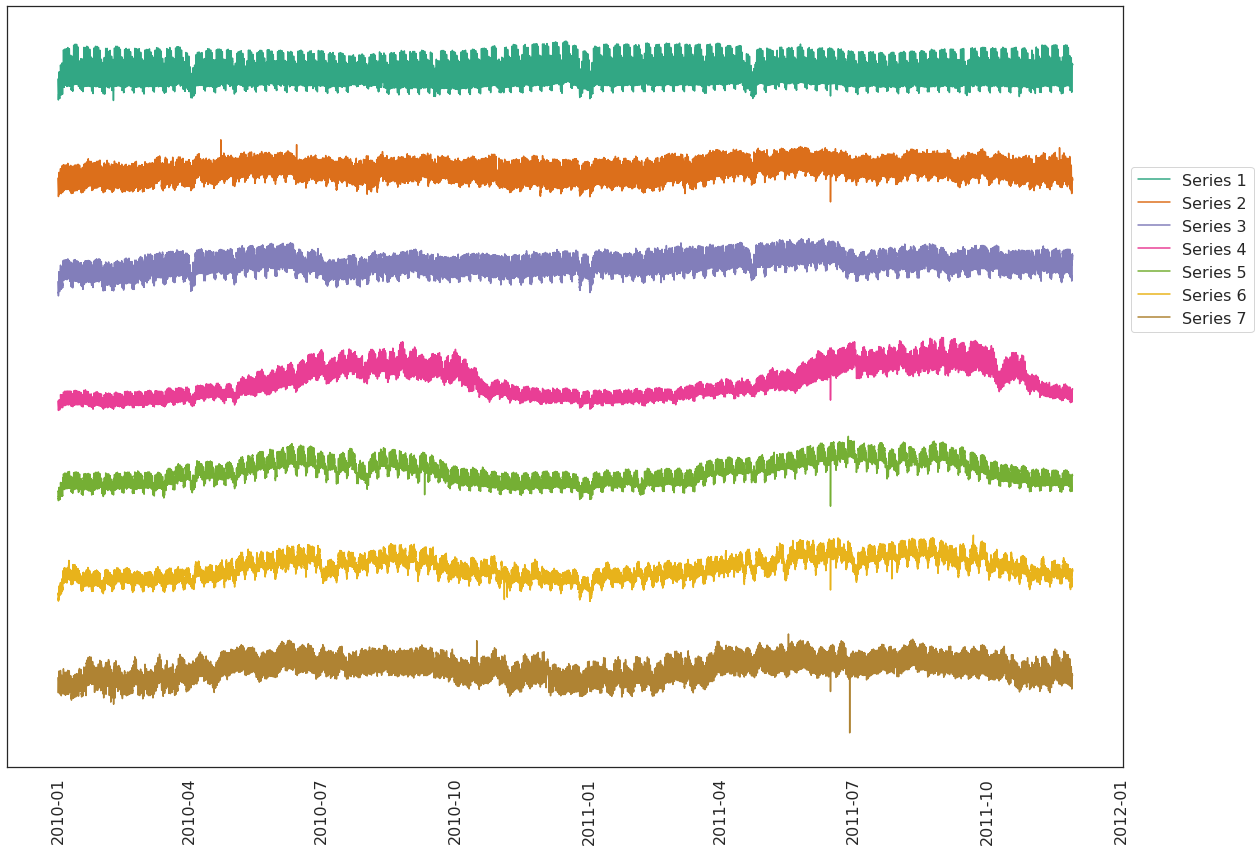

In [95]:
if  False:
    i = 0
    j = 0
    cmap = plt.cm.Dark2 #tab20 https://matplotlib.org/stable/gallery/color/colormap_reference.html
    fig, ax = plt.subplots(figsize=(20,14))
    for ts in df_5:
      max_t = df_5[ts].max()
      plt.plot(df_5[ts].index, df_5[ts] / max_t + j, c = cmap(i), label='Series '+str(i+1),alpha=.9)
      i += 1
      j -= 1
    plt.yticks([])
    plt.xticks(rotation=90, fontsize=16)
    plt.legend(bbox_to_anchor=(1, 0.8), prop={'size': 16})
    plt.savefig('series.pdf')
    plt.show()

# Un pronóstico persistente multiperiodo

In [96]:
#from numpy.lib.function_base import append
def persistent(serie,n=1):
    out=[]
    for i in range(n):        
        out.append(serie[len(serie)-1])
    return(out)

# Preparamos cross-validation para pruebas

Usaremos la metodología propuesta por Rob Hydman [cross-validation in time series](https://robjhyndman.com/hyndsight/tscv/#:~:text=Time%20series%20cross%2Dvalidation,used%20in%20constructing%20the%20forecast.
)


In [97]:
## https://robjhyndman.com/hyndsight/tscv/#:~:text=Time%20series%20cross%2Dvalidation,used%20in%20constructing%20the%20forecast.
## ... year 2000                                                                                                    year 2001
## ... january···february···march···april···may···june···july···august···september···october···november···december···january···february···march···april···may···june···july···august···september···october···november
##    |                                   |      |
##    |<------------- train ------------->|<test>|
##    |<-january·february···march···april->|<may>|
##            |<-february···march···april···may->|<june>|
##                      |<- march···april···may···june ->|<-july->|
##                              |<- april···may···june···july->|<-august->|
##                                     |<-- may···june···july···august->|<-september->|
##                                             |<-june···july···august···september->|<-october->|
##                                                    |<-july···august···september···october->|<-november->|
##                                                           |<-august···september···october···november->|<-december->| ...

## Extraemos la primera serie
serie = df_5.SERIE1.tolist()
equi  = int(len(serie)/23)

## positions_test: guarga las posiciones tt y tf de cada k-folds
start = 4 * equi
positions_test = []
for i in range(start,len(serie)-equi,equi):
    positions_test.append((i-start,i,i+equi))
print(positions_test)

## Extraer las posiciones del inicio de los meses de la serie
#for i in df_5['Data']:
#    positions_test.append(i)
#t_0=[0,]

[(0, 34892, 43615), (8723, 43615, 52338), (17446, 52338, 61061), (26169, 61061, 69784), (34892, 69784, 78507), (43615, 78507, 87230), (52338, 87230, 95953), (61061, 95953, 104676), (69784, 104676, 113399), (78507, 113399, 122122), (87230, 122122, 130845), (95953, 130845, 139568), (104676, 139568, 148291), (113399, 148291, 157014), (122122, 157014, 165737), (130845, 165737, 174460), (139568, 174460, 183183), (148291, 183183, 191906), (157014, 191906, 200629)]


# Meta-función básica de pronóstico de un periodo (persistente)



In [98]:

# >>> provisional para pruebas internas (comentar)
#positions_test= [(0, 34892, 34892)]
positions_test= [(0, 34892, 34992), (8723, 43615, 43715), (17446, 52338, 52438)]
positions_test= [(0, 34892, 43615), (8723, 43615, 52338), (17446, 52338, 61061)]
positions_test= [(0, 34892, 43615)]



In [99]:
## ... time serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie ...
##                |                                               |           |       |
##                |                                               |<---n_p--->|       |
##                |<------------------ train -------------------->|<-------test------>|
##                to                                              tt                 tf 

n_p = 1  ## Numero de periodos de pronóstico por paso

forecast_ = []
time_     = []
for to,tt,tf in positions_test:
    j=0
    for i in range(tt,tf,n_p):
        t_o = time.time()
        forecast_=forecast_+persistent(serie[to+j:tt+j],n_p)
        time_.append(time.time() - t_o)
        j=j+n_p

In [100]:
test_ = []
for to,tt,tf in positions_test:
      test_ = test_+serie[tt:tf]
print(len(forecast_))
print(len(test_))

8723
8723


In [101]:
mae_p  = mean_absolute_error(test_,forecast_)
mape_p = mean_absolute_percentage_error(test_,forecast_)
bias_p = bias.bias(test_,forecast_)
print('mae_p=',mae_p,'mape_p=',mape_p,'bias=',bias_p)

mae_p= 31.301569856012836 mape_p= 0.005073162039986859 bias= 0.29870729455462564


# Meta-función básica de n periodos (persistente)
Se usan 30 periodos equivalentes a dos horas y media en intervalos de cinco minutos


In [102]:
n_p = 30 ## Numero de periodos por salto
forecast2_ = []
time2_     = []
for to,tt,tf in positions_test:
    j=0
    for i in range(tt,tf,n_p):
        t_o = time.time()
        forecast2_=forecast2_+persistent(serie[to+j:tt+j],n_p)
        time2_.append(time.time() - t_o)
        j=j+n_p
    modu=(tf-tt)%n_p
    if modu > 0:
        forecast2_=forecast2_[0:(+modu-n_p)]
            

In [103]:
print(len(forecast2_))
print(len(test_))

8723
8723


## Gráficas

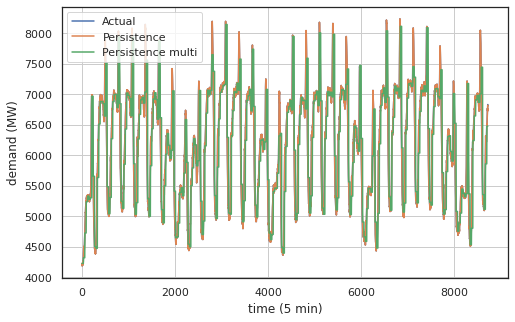

In [104]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(test_[0:35892],      label='Actual')
ax.plot(forecast_[0:35892],  label='Persistence')
ax.plot(forecast2_[0:35892], label='Persistence multi')
ax.set(xlabel='time (5 min)', ylabel='demand (MW)')
ax.grid()
plt.legend()
fig.savefig("test.pdf")
plt.show()


In [105]:
mae_mp  = mean_absolute_error(test_,forecast2_)
mape_mp = mean_absolute_percentage_error(test_,forecast2_)
bias_mp  = bias.bias(test_,forecast2_)
print('mae_mp=',mae_mp,'mape_mp=',mape_mp,'bias=',bias_mp)

mae_mp= 324.86606189941534 mape_mp= 0.05337135760931333 bias= 7.148168509251428


# Meta-función básica de pronóstico de un periodo (análogo)



In [ ]:
## ... time serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie ...
##                |                                               |           |       |
##                |                                               |<---n_p--->|       |
##                |<------------------ train -------------------->|<-------test------>|
##                to                                              tt                 tf 

n_p = 1   ## Numero de periodos por salto
forecast3_ = []
forecast4_ = []
time3_     = []
n=0
err=0
for to,tt,tf in positions_test:
    j=0
    nn=n
    for i in range(tt,tf,n_p):
        t_o = time.time()
        ## Parámetros del método Análogo
        vsele = 288 ## Número de periodos en una ventana
        k     = 6   ## k:   número de vecinos mas cercanos
        tol   = 0.8 ## tol: porcentaje de tolerancia de cercania entre vecinos
        d     = 'pearson'
        m     = 'OLS'
        X_train = numpy.array(serie[to+j:tt+j])
        try:
            pred_, t_sel_, t_reg_ = analogo_knn(X_train, vsele=vsele, k=k, tol=tol, typedist=d, typereg=m, verbose=False)
        except:
            #pred_=[X_train[-1]]; t_sel_=0; t_reg_=0
            print(">>> Pronóstico no calculado, pos:", tt )
            err = err+1
        print(pred_)
        forecast3_ = forecast3_ + pred_[0]
        if j >= 20 :
            array1 = np.array(forecast3_[nn:-n_p])
            array2 = np.array(serie[tt:tt+j])
            epsilon = np.subtract(array1,array2)
            ar = AutoReg(epsilon, lags=1).fit()           
            delta = ar.forecast(1)
            forecast4_ = forecast4_ + [pred_[0]- delta]
        else:
            forecast4_ = forecast3_
        time3_.append(time.time() - t_o)
        j=j+n_p
        n=n+1
    modu=(tf-tt)%n_p
    if modu > 0:
        forecast3_=forecast3_[0:(+modu-n_p)]
        forecast4_=forecast4_[0:(+modu-n_p)]
print('>>> Número de pronósticos no calculados',err)
            

In [107]:
pred_, t_sel_, t_reg_ = analogo_knn(X_train, vsele=vsele, k=k, tol=tol, typedist=d, typereg=m, verbose=False)
pred_

>>> analogo_knn: Pronóstico no calculado


[4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.163965,
 4218.

In [ ]:
print(len(forecast3_))
print(len(forecast4_))

In [ ]:
if False:
    if False:
        fig, ax = plt.subplots()
        ax.legend(['First line', 'Second line'])
        serie1=serie[positions[0]:positions[0]+2*vsele]
        serie2=serie[positions[1]:positions[1]+2*vsele]
        serie3=serie[positions[2]:positions[2]+2*vsele]
        serie4=serie[positions[3]:positions[3]+2*vsele]
        serie5=serie[positions[4]:positions[4]+2*vsele]
        serie6=serie[positions[5]:positions[5]+2*vsele]
        ax.plot(serie1, label='X$_1$')
        ax.plot(serie2, label='X$_2$')
        ax.plot(serie3, label='X$_3$')
        ax.plot(serie4, label='X$_4$')
        ax.plot(serie5, label='X$_5$')
        ax.plot(serie6, label='X$_6$')
        ax.plot(Y,label='Y', linewidth=3, color='r')   
        c = np.concatenate((Y,prediction_Y2), axis=0)   
        ax.plot(c, label='$Y\'$', linewidth=3, color='r',linestyle='--')      
        plt.legend()
        plt.axvline(x = vsele,linestyle='-.') # '-', '--', '-.', ':',
        ax.set(xlabel='time (5 min)', ylabel='demand (MW)') #title='High correlation windows'
        ax.grid()
        fig.savefig("temp.pdf")
        plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(test_,      label='Actual') 
ax.plot(forecast_ , label='Persistence')
ax.plot(forecast3_, label='An Pearson+OLS')
ax.plot(forecast4_, label='AnMA Pearson+OLS')
ax.set(xlabel='time (5 min)', ylabel='demand (MW)')
ax.grid()
plt.legend()
fig.savefig("test2.pdf")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(test_,      label='Actual') 
#ax.plot(forecast_ , label='Persistence')
ax.plot(forecast3_, label='An Pearson+OLS')
ax.plot(forecast4_, label='AnMA Pearson+OLS')
ax.set(xlabel='time (5 min)', ylabel='demand (MW)')
ax.grid()
plt.legend()
plt.axis([100,  200, 6000, 8000])
fig.savefig("bias.pdf")

plt.show()

In [ ]:
a=0;b=200
mae_p  = mean_absolute_error(test_[a:b],forecast_[a:b])
mape_p = mean_absolute_percentage_error(test_[a:b],forecast_[a:b])
bias_p = bias.bias(test_[a:b],forecast_[a:b])
print('mape_p=',mape_p,'mae_p=',mae_p,'bias=',bias_p)

In [ ]:
mae_a  = mean_absolute_error(test_[a:b],forecast3_[a:b])
mape_a = mean_absolute_percentage_error(test_[a:b],forecast3_[a:b])
bias_a = bias.bias(test_[a:b],forecast3_[a:b])
print('mape_a=',mape_a,'mae_a=',mae_a,'bias_a=',bias_a)

In [ ]:
mae_ma  = mean_absolute_error(test_[a:b],forecast4_[a:b])
mape_ma = mean_absolute_percentage_error(test_[a:b],forecast4_[a:b])
bias_ma = bias.bias(test_[a:b][a:b],forecast4_[a:b])
print('mape_ma=',mape_ma,'mae_ma=',mae_ma,'bias_ma=',bias_ma)

In [ ]:
## Dibujamos un boxplot
data = [diff(test_[a:b],forecast_[a:b]), diff(test_[a:b],forecast2_[a:b]), diff(test_[a:b],forecast3_[a:b])]
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(['Persistence', 'An\n(Pearson+RF)', 'AnMA\n(Pearson+RF)'])
fig.savefig("boxplot.pdf")
plt.show()

In [ ]:
labels = ['Persistence', 'An\n(Pearson+RF)', 'AnMA\n(Pearson+RF)', 'dist', 'disp']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "#FF0000"; # 'pink', 'lightblue', 'lightgreen',
plt.tick_params(colors = LETRASNARA, which='both')
bplot1 = axes.boxplot(data,
                         vert=True,          # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels,)     # will be used to label x-ticks
#axes.set_title('Accuracy',fontsize='x-large',color = LETRASNARA)
#plt.tick_params(colors = LETRASNARA, which='both')
colors = ['pink', 'lightblue', 'lightgreen',LILA, AZUL] # fill with colors
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
axes.yaxis.grid(True) # adding horizontal grid lines
axes.set_xlabel('Configuraciones de red',fontsize='large',color = LETRASNARA)
axes.set_ylabel('')
namefile = 'boxplot.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

In [ ]:
e=2
n=5
a=[e] * n
a